<a href="https://colab.research.google.com/github/manmorjim/ai_playground/blob/main/interview/2nd_problem/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing the environment

Install main dependencies for the code

In [ ]:
!wget 'http://app.goldenspear.com/shirts.tar.gz'

--2021-03-16 23:35:30--  http://app.goldenspear.com/shirts.tar.gz
Resolving app.goldenspear.com (app.goldenspear.com)... 209.133.216.29
Connecting to app.goldenspear.com (app.goldenspear.com)|209.133.216.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 682520671 (651M) [application/octet-stream]
Saving to: ‘shirts.tar.gz’

shirts.tar.gz       100%[===================>] 650.90M  94.1MB/s    in 7.0s    

2021-03-16 23:35:37 (92.7 MB/s) - ‘shirts.tar.gz’ saved [682520671/682520671]



In [ ]:
!tar xvzf shirts.tar.gz

Streaming output truncated to the last 5000 lines.
shirt_dataset/unlabeled/59829413_0.jpg
shirt_dataset/unlabeled/62669167_0.jpg
shirt_dataset/unlabeled/60243445_0.jpg
shirt_dataset/unlabeled/557446069aab5c51d56c754a.png
shirt_dataset/unlabeled/59842607_0.jpg
shirt_dataset/unlabeled/560529c2f1773512f968f95b.png
shirt_dataset/unlabeled/57063cbccf1e8c7844b674cf.jpg
shirt_dataset/unlabeled/577022dbcf1e8c09f1afd20b.jpg
shirt_dataset/unlabeled/56e74213cf1e8c4041b0ac6d.jpg
shirt_dataset/unlabeled/60214554_0.jpg
shirt_dataset/unlabeled/62669055_0.jpg
shirt_dataset/unlabeled/59871000_0.jpg
shirt_dataset/unlabeled/55c1ef8e3a67b33543ea5747.png
shirt_dataset/unlabeled/58082257_0.jpg
shirt_dataset/unlabeled/557437469aab5c51a1592ccd.png
shirt_dataset/unlabeled/56e748a6cf1e8c4041b2a0bd.jpg
shirt_dataset/unlabeled/5770777acf1e8c09f1cd0efa.jpg
shirt_dataset/unlabeled/57703888cf1e8c09f1b0f180.jpg
shirt_dataset/unlabeled/56d9dbaacf1e8c0318b7bdf1.jpg
shirt_dataset/unlabeled/58131793_0.jpg
shirt_dataset/u

# Problem analysis

Our main problem here is that the labeled dataset is too small, just 10 samples. By this way we cannot build a accurated model using supervised learning due to the training set si too small.

So I think the best option here would be creating a model using unsupervised learning like K-Means in order to group the images in two clusters: `blue shirts` and `no blue shirts`


### Unsupervised learning: K-Means Alogirithm

The most of the images are similar: they are shirts and they are *usually* the focus of the image therefore the K-Means algorithm will create two clusters which will be too close to each other.

To create two clusters that are well separated from each other we will pre-process all the images in order to paint **blue pixels as white** pixels and **the other ones as black**. By this way the most images with blue shirts will be similar and discernible from the other ones.

Import classes and functions

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil
import cv2
import os
from google.colab.patches import cv2_imshow

train_dir = Path('shirt_dataset/unlabeled')
test_dir = Path('shirt_dataset/labeled')

Pre-processed images to just keep blue pixels:

In [ ]:
!mkdir -p shirt_dataset/preprocessed
!mkdir -p shirt_dataset/preprocessed_test

Any colour in the hue range from 180 to 300 can be considered blue, since that's the primary colour that is dominant.

Then you have to factor in things like "it still looks cyan" (since green is far more perceptually bright than blue) and stuff like that, there's really no hard-and-fast definition.

So what you could do is say "if( max( red, green, blue) == blue) then it's blue" and nobody can fault you for it.

So the first option I took was this thought, but there are several images which qualify as blue ones but they are not. As is the case with white shirts:

In [ ]:
def keep_blue_pixels(img, size):
  blue_image = np.zeros((size[0], size[1], 3), np.uint8)
  for i in range(size[0]):
    for j in range(size[1]):
      pixel = img[i][j]
      if ((int(pixel[0]) > int(pixel[1])) and (int(pixel[0]) > int(pixel[2]))):
        blue_image[i][j] = (255, 255, 255) # put it as white
      else:
        blue_image[i][j] = (0, 0, 0)

  return blue_image

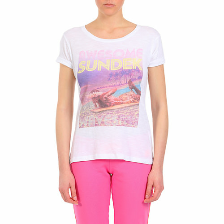

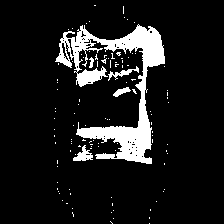

In [ ]:
size = (224, 224)

img = cv2.resize(cv2.imread('/content/shirt_dataset/unlabeled/55744ba09aab5c51dd887954.png'), size)
cv2_imshow(img)
pre_img = keep_blue_pixels(img, size)
cv2_imshow(pre_img)

To improve the filter I decided to use a hue mask with openCV with a lower and upper value:

In [ ]:
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

def apply_blue_mask(img, size):
  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  blue_mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
  return blue_mask

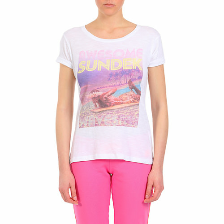

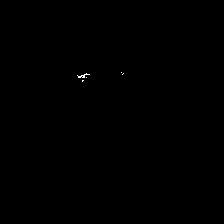

In [ ]:
img = cv2.resize(cv2.imread('/content/shirt_dataset/unlabeled/55744ba09aab5c51dd887954.png'), size)
cv2_imshow(img)
pre_img = apply_blue_mask(img, size)
cv2_imshow(pre_img)

In [ ]:
preprocessed_dir = Path('shirt_dataset/preprocessed')
preprocessed_test_dir = Path('shirt_dataset/preprocessed_test')

# preprocess train set
for file in train_dir.iterdir():
  img_path = str(file)
  filename = os.path.basename(img_path)
  img = cv2.resize(cv2.imread(img_path), size)
  img = apply_blue_mask(img, size)
  cv2.imwrite(f"{str(preprocessed_dir)}/{filename}", img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

# preprocess test set
for file in test_dir.iterdir():
  img_path = str(file)
  filename = os.path.basename(img_path)
  img = cv2.resize(cv2.imread(img_path), size)
  img = apply_blue_mask(img, size)
  cv2.imwrite(f"{str(preprocessed_test_dir)}/{filename}", img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

Using the model [inception_v3](https://arxiv.org/abs/1512.00567) to extract the features from the pre-processed images

In [ ]:
model = InceptionV3(weights='imagenet', include_top=False)

def image_to_feature_vector(img):
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  feature = model.predict(x)
  feature = feature.flatten()
  return feature

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
img_names = []
features_train = []

img_test = []
features_test = []

# train features
for file in preprocessed_dir.iterdir():
  img = image.load_img(str(file), color_mode='rgb', target_size=(224, 224))
  feature = image_to_feature_vector(img)
  features_train.append(feature)
  img_names.append(os.path.basename(str(file)))

# test features
for file in preprocessed_test_dir.iterdir():
  img = image.load_img(str(file), color_mode='rgb', target_size=(224, 224))
  feature = image_to_feature_vector(img)
  features_test.append(feature)
  img_test.append(os.path.basename(str(file)))

Trains our K-Means algorithm in order to find two clusters (k = 2):

In [ ]:
k = 2
clusters = KMeans(k, random_state = 40)
clusters.fit(features_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=40, tol=0.0001, verbose=0)

In [ ]:
results = clusters.predict(features_test)

In [ ]:
results

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

There is a labeled image which is not being classfied as `blue shirt`. This is because the blue filter does not work with that image:

In [ ]:
from scipy import stats

blue_cluster_id = stats.mode(results)[0][0]

In [ ]:
failed_img_name = img_test[np.where(results != blue_cluster_id)[0][0]]
failed_img_path = f"/content/shirt_dataset/preprocessed_test/{failed_img_name}"

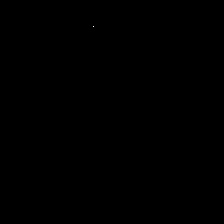

In [ ]:
img = image.load_img(failed_img_path, color_mode='rgb', target_size=(224, 224))
img

There is another problem with images which have a brighter blue like:

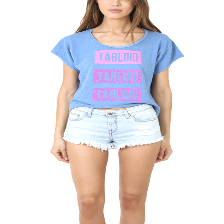

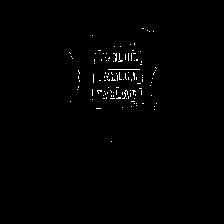

In [ ]:
img = cv2.resize(cv2.imread('/content/shirt_dataset/unlabeled/55c21f10799d5b65f1826169.png'), size)
cv2_imshow(img)
pre_img = apply_blue_mask(img, size)
cv2_imshow(pre_img)

This shows us how important is to choose the right filter for blue pixels.

Finally, we create a folder in order to copy there all the images which belong to the `blue shirts` cluster:

In [ ]:
!mkdir -p shirt_dataset/blue_cluster

In [ ]:
i = 0
for cluster_id in clusters.labels_:
  if (cluster_id == blue_cluster_id):
    blue_tshirt_file = img_names[i]
    shutil.copy(f"shirt_dataset/unlabeled/{blue_tshirt_file}", f"shirt_dataset/blue_cluster/{blue_tshirt_file}")
  i = i + 1

# Models validation

Let's see the capacity of the model by classifying images downloaded from internet from a search "*blue shirts*" and "*red shirts*".

Install [google-images-download](https://github.com/ultralytics/google-images-download) and its dependencies in order to download images from bing: 

In [ ]:
!mkdir -p download/blue
!mkdir -p download/red
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
!git clone https://github.com/ultralytics/google-images-download
!pip install -U -r google-images-download/requirements.txt

     |████████████████████████████████| 911kB 15.6MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InReleas

Prepare selenium (Chrome headless)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time 

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver', chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: use options instead of chrome_options
  if __name__ == '__main__':


In [ ]:
def download_images(query, download_dir, prefix_name, num_images=100):
  wd.get('https://www.google.ca/imghp?hl=en&tab=ri&authuser=0&ogbl')
  box = wd.find_element_by_xpath('//*[@id="sbtc"]/div/div[2]/input')

  box.send_keys(query)
  box.send_keys(Keys.ENTER)

  #Will keep scrolling down 5 times
  last_height = wd.execute_script('return document.body.scrollHeight')
  for i in range(4):
      wd.execute_script('window.scrollTo(0,document.body.scrollHeight)')
      time.sleep(2)
      new_height = wd.execute_script('return document.body.scrollHeight')
      try:
          wd.find_element_by_xpath('//*[@id="islmp"]/div/div/div/div/div[5]/input').click()
          time.sleep(2)
      except:
          pass
      if new_height == last_height:
          break
      last_height = new_height

  # download images
  for i in range(1,num_images):
    try:
      wd.find_element_by_xpath(f"//*[@id=\"islrg\"]/div[1]/div[{i}]/a[1]/div[1]/img").screenshot(f"{download_dir}/{prefix_name}_{i}.png")
    except:
      pass

Download blue shirts:

In [ ]:
download_images('blue shirt', 'download/blue', 'blue_shirt')

Download red shirts:

In [ ]:
download_images('red shirt', 'download/red', 'red_shirt')

Preprocess downloaded images:

In [ ]:
!mkdir -p download/preprocessed/blue
!mkdir -p download/preprocessed/red

In [ ]:
downloaded_blue_dir = Path('download/blue')
preproc_blue_dir = Path('download/preprocessed/blue')
blue_names = []
blue_features = []

# preprocess blue set
for file in downloaded_blue_dir.iterdir():
  img_path = str(file)
  filename = os.path.basename(img_path)
  preproc_image_dir = f"{str(preproc_blue_dir)}/{filename}"

  img = cv2.resize(cv2.imread(img_path), size)
  img = apply_blue_mask(img, size)
  cv2.imwrite(preproc_image_dir, img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

  img = image.load_img(preproc_image_dir, color_mode='rgb', target_size=(224, 224))
  feature = image_to_feature_vector(img)
  blue_features.append(feature)
  blue_names.append(filename)

downloaded_red_dir = Path('download/red')
preproc_red_dir = Path('download/preprocessed/red')
red_names = []
red_features = []

# preprocess red set
for file in downloaded_red_dir.iterdir():
  img_path = str(file)
  filename = os.path.basename(img_path)
  preproc_image_dir = f"{str(preproc_red_dir)}/{filename}"

  img = cv2.resize(cv2.imread(img_path), size)
  img = apply_blue_mask(img, size)
  cv2.imwrite(preproc_image_dir, img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

  img = image.load_img(preproc_image_dir, color_mode='rgb', target_size=(224, 224))
  feature = image_to_feature_vector(img)
  red_features.append(feature)
  red_names.append(filename)

Check accuray models with the downloaded images:

In [ ]:
blue_results = clusters.predict(blue_features)
red_results = clusters.predict(red_features)

In [ ]:
import collections

blue_accuracy = collections.Counter(blue_results)[blue_cluster_id] / len(blue_results)
blue_accuracy

0.75

In [ ]:
red_accuracy = (len(red_results) - collections.Counter(red_results)[blue_cluster_id]) / len(red_results)
red_accuracy

0.8020833333333334

# Final summary



```
# Tiene formato de código
```

With more time I would apply some [background removal](https://towardsdatascience.com/background-removal-with-deep-learning-c4f2104b3157) as clean method in order to remove all the noise introduced by background with colors and objects.

Then I'd apply some contour detect in order to keep just shirts and remove all the elements like people, pants, etc.

Finally I would like to improve the blue filter with openCV in order to keep all the blue colors. Pending to check some color theory to do this (like https://www.youtube.com/watch?v=LKnqECcg6Gw)